# Process GWTC Data

This notebook processes the public data releases from GWTC-1, GWTC-2, GWTC-2.1, and GWTC-3 and saves reduced hdf5 posterior sample files into a specified directory. 

File format for h5 files: h5py.File('event_name', key='waveform_model/posterior_samples'). 

Prior weights are saved as h5py.File('event_name', key='waveform_model/prior_samples')

In [26]:
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
import os
from tqdm import tqdm
from IPython.core.debugger import set_trace

from astropy import cosmology
from astropy.cosmology import z_at_value
import astropy.units as u
cosmo = cosmology.Planck18

import matplotlib.pyplot as plt

import bounded_Nd_kde

# Put in your path to the samples. File names should be GWXXXXXX_XX.h5. 

GWTC1_path = '/Users/michaelzevin/research/ligo/data_releases/PE/GWTC-1_sample_release/'
GWTC2_path = '/Users/michaelzevin/research/ligo/data_releases/PE/GWTC-2_sample_release/'
GWTC2p1_path = '/Users/michaelzevin/research/ligo/data_releases/PE/GWTC-2.1_sample_release/'
GWTC3_path = '/Users/michaelzevin/research/ligo/data_releases/PE/GWTC-3_sample_release/'

# bounds for prior KDE
param_lims = {'mc_src':(0,150), 'q':(0,1), 'chieff':(-1,1), 'z':(0,2)}

output_directory = '/Users/michaelzevin/research/model_selection/gwtc3/data/gw_events/'

In [2]:
# conversion function

def m1m2_to_mchirp(m1,m2):
    return (m1*m2)**(3./5) / (m1+m2)**(1./5)

def m1m2_to_mtot(m1,m2):
    return m1+m2

def m1m2_to_q(m1,m2):
    # q is defined as m2/m1 with m2<=m1
    q = m2/m1
    pos_idxs = np.argwhere(q > 1)
    q[pos_idxs] = m1[pos_idxs]/m2[pos_idxs]
    return q

def m1m2_to_eta(m1,m2):
    eta = (m1*m2) / (m1+m2)**2
    return eta

def components_to_chieff(m1,m2,a1,a2,costilt1,costilt2):
    return (m1*a1*costilt1 + m2*a2*costilt2) / (m1+m2)

# create interpolant for determining redshifts from luminosity distances
dL_max = 20000 # Mpc
dL_vals = np.linspace(0.0001, dL_max, 10000)
redshift_vals = np.asarray([z_at_value(cosmo.luminosity_distance, dL*u.Mpc) for dL in dL_vals])
z_from_dL = interp1d(dL_vals, redshift_vals)

def dL_to_redshift(dL):
    # Input distance in Mpc
    # Use interpolant above to speed this up
    return z_from_dL(dL)


params we are currently saving: ['m1', 'm2', 'mchirp', 'mtot', 'q', 'eta', 'chieff', 'dL', 'z']

### Test out prior KDE

In [3]:
from importlib import reload
reload(bounded_Nd_kde)

<module 'bounded_Nd_kde' from '/Users/michaelzevin/research/utilities/bounded_Nd_kde.py'>

GW151226.h5
GW170823.h5
GW170809.h5
GW170104.h5
GW170818.h5
GW170608.h5
GW170729.h5
GW151012.h5
GW170814.h5
GW150914.h5


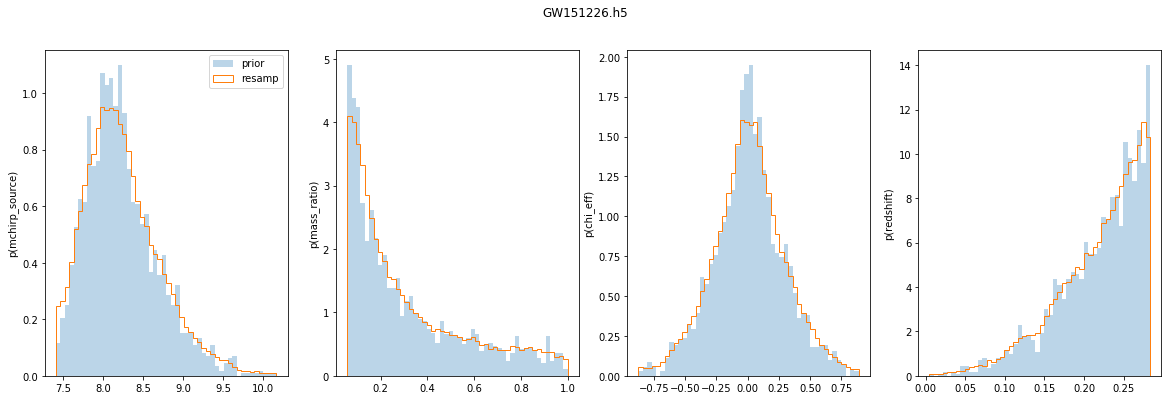

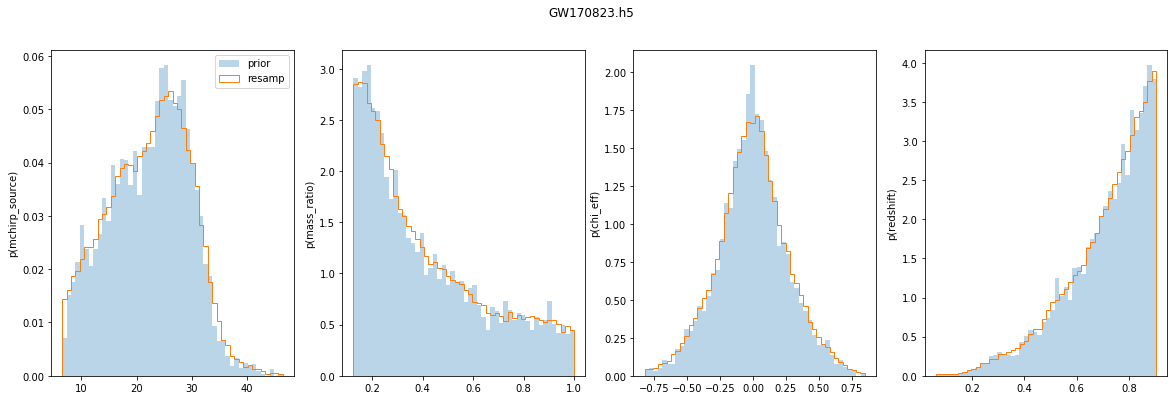

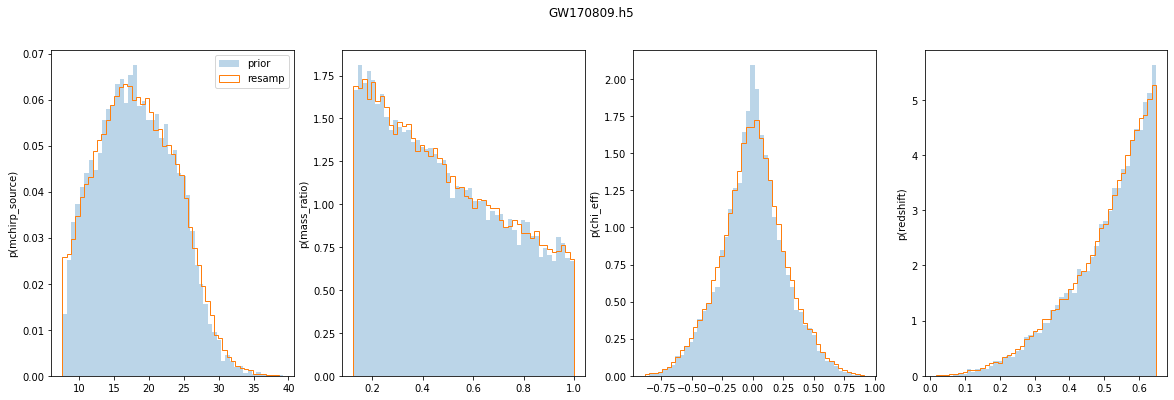

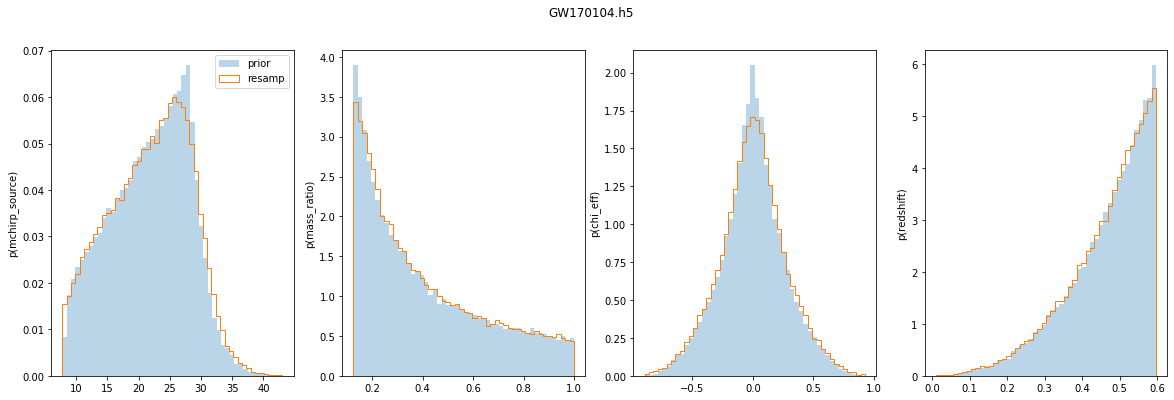

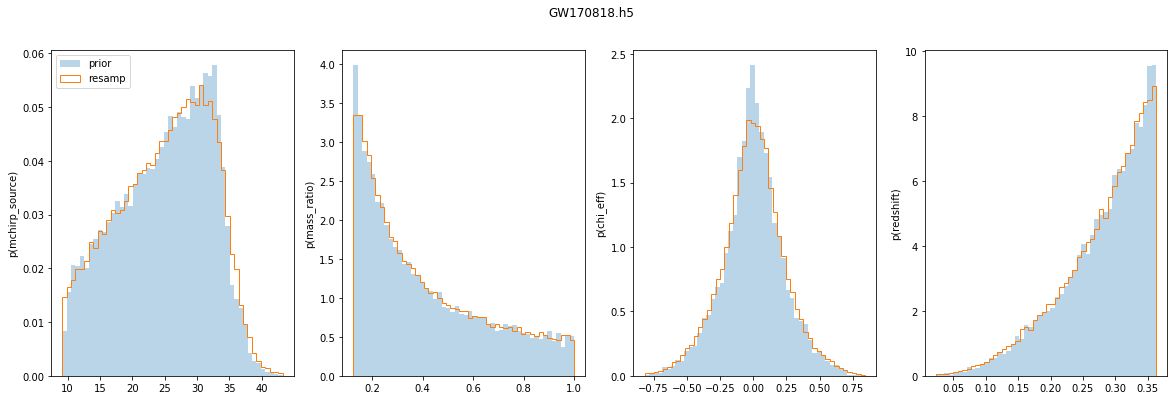

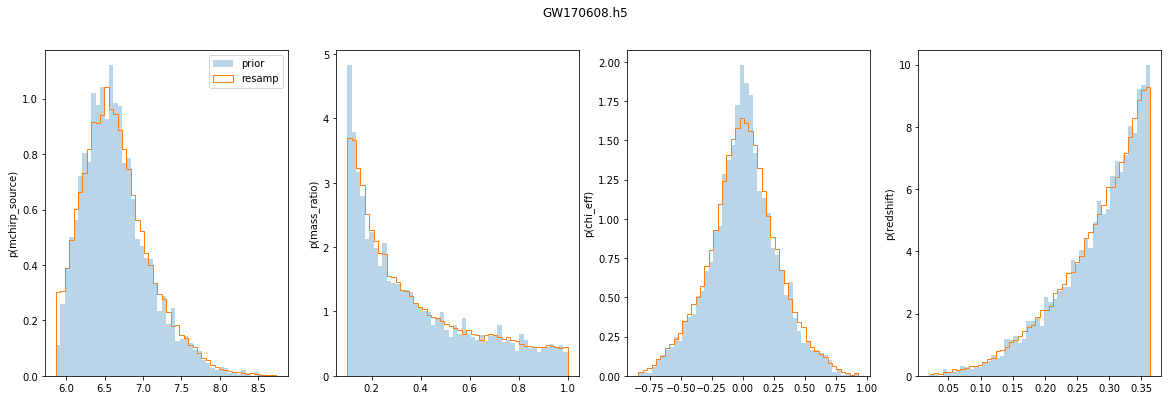

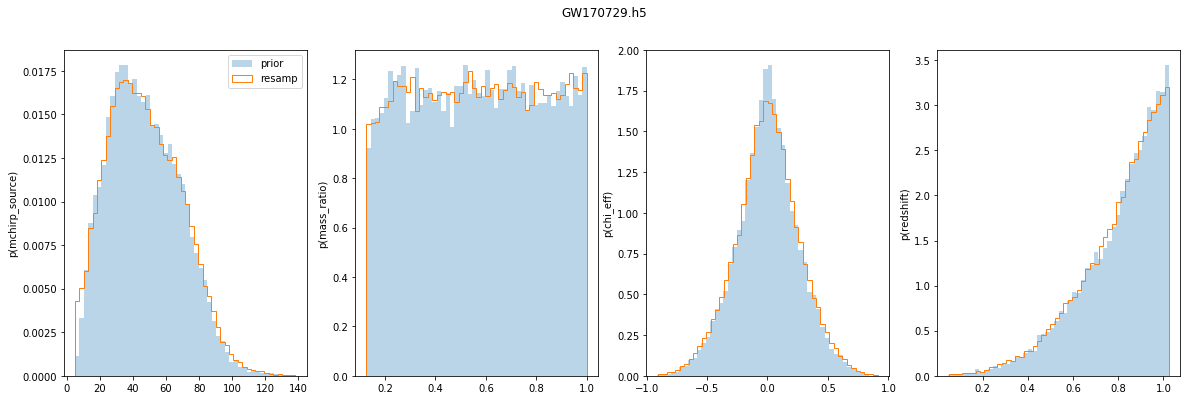

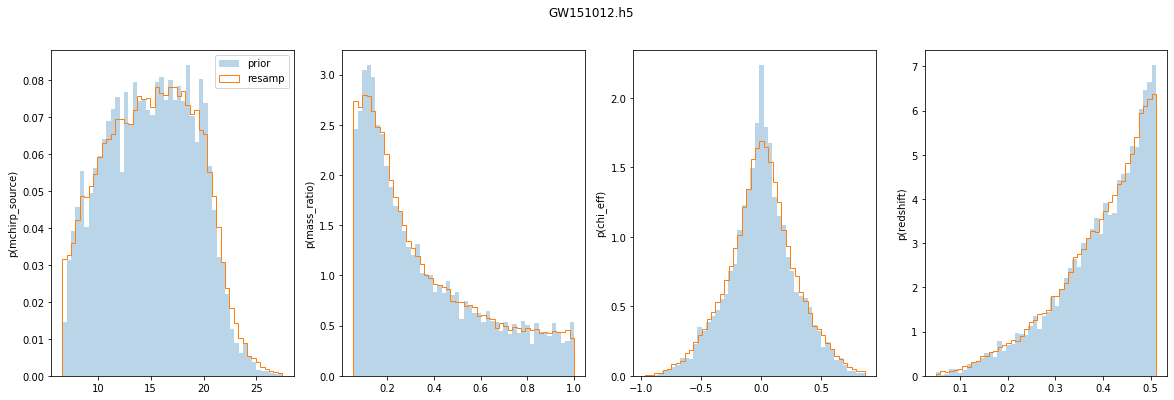

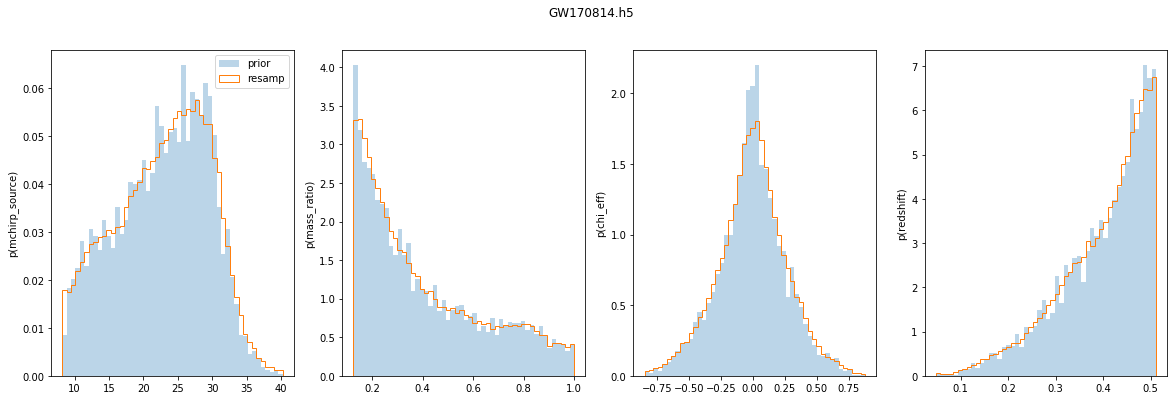

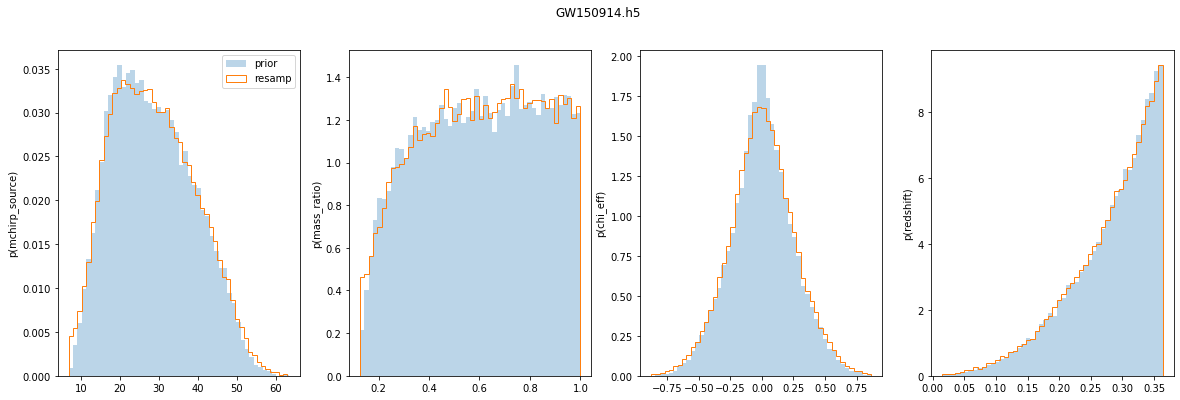

In [4]:
file_path = GWTC1_path
for event_file in os.listdir(file_path):
    if any([x in event_file for x in ['GW170817','GW190425','GW190426','GW190814']]):
        continue
    if event_file[:2] != 'GW':
        continue
    if file_path==GWTC2_path:
        # remove marginal events
        if 'prior.npy' not in event_file:
            continue
            
    print(event_file)
        
    if file_path==GWTC1_path:
        prior = pd.read_hdf(os.path.join(file_path,event_file), key='prior')
        
        prior['redshift'] = dL_to_redshift(prior['luminosity_distance_Mpc'])
        prior['mass_1_source'] = prior['m1_detector_frame_Msun']/(1+prior['redshift'])
        prior['mass_2_source'] = prior['m2_detector_frame_Msun']/(1+prior['redshift'])
        prior['mass_ratio'] = prior['mass_2_source']/prior['mass_1_source']
        prior['mchirp_source'] = m1m2_to_mchirp(prior['mass_1_source'], prior['mass_2_source'])
        prior['chi_eff'] = components_to_chieff(prior['mass_1_source'], prior['mass_2_source'], prior['spin1'], prior['spin2'], prior['costilt1'], prior['costilt2'])

    elif file_path==GWTC2_path:
        prior = pd.DataFrame(np.load(os.path.join(file_path, event_file)))
        
        # special treatment for certain prior files
        if 'GW190412' in event_file:
            prior['redshift'] = dL_to_redshift(prior['luminosity_distance'])
            prior['mass_1_source'] = prior['mass_1']/(1+prior['redshift'])
            prior['mass_2_source'] = prior['mass_2']/(1+prior['redshift'])
            
        prior['mchirp_source'] = m1m2_to_mchirp(prior['mass_1_source'], prior['mass_2_source'])
        

    X = np.atleast_2d([prior['mchirp_source'],prior['mass_ratio'],prior['chi_eff'],prior['redshift']])
    Bounds = np.atleast_2d([(prior['mchirp_source'].min(),prior['mchirp_source'].max()), (prior['mass_ratio'].min(),prior['mass_ratio'].max()), \
                            (prior['chi_eff'].min(),prior['chi_eff'].max()), (prior['redshift'].min(),prior['redshift'].max())])

    prior_kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=0.05)
    
    # check normalization (should be 0.04 for 4D KDE)
    #print('   {:0.3f}'.format(prior_kde.integrate_box([prior['mchirp_src'].min(), prior['mass_ratio'].min(), prior['chi_eff'].min(), prior['redshift'].min()], \
    #                              [prior['mchirp_src'].max(), prior['mass_ratio'].max(), prior['chi_eff'].max(), prior['redshift'].max()])))

    # check 1D distributions against KDE resample
    N=50000

    fig, axs = plt.subplots(1,4, figsize=(20,6))

    resamp = prior_kde.bounded_resample(N)
    for idx, param in enumerate(['mchirp_source','mass_ratio','chi_eff','redshift']):
        axs[idx].set_ylabel('p({:s})'.format(param))

        h, bins, _ = axs[idx].hist(prior[param], bins=50, density=True, alpha=0.3, label='prior')
        h, bins, _ = axs[idx].hist(resamp[idx], bins=50, density=True, histtype='step', label='resamp')

    axs[0].legend()
    plt.suptitle(event_file)


### GWTC-1 Events

In [17]:
for gw_file in sorted(os.listdir(GWTC1_path)):
    # remove BNS event
    gw_name = gw_file.split('.')[0]
    if gw_name == 'GW170817':
        continue
    print(gw_name)

    # skip if we already constructed the file
    if os.path.join(gw_name+'.hdf5') in os.listdir(output_directory):
        continue

    # kde the prior
    prior = pd.read_hdf(os.path.join(GWTC1_path,gw_file), key='prior')

    prior['redshift'] = dL_to_redshift(prior['luminosity_distance_Mpc'])
    prior['mass_1_source'] = prior['m1_detector_frame_Msun']/(1+prior['redshift'])
    prior['mass_2_source'] = prior['m2_detector_frame_Msun']/(1+prior['redshift'])
    prior['mass_ratio'] = prior['mass_2_source']/prior['mass_1_source']
    prior['mchirp_source'] = m1m2_to_mchirp(prior['mass_1_source'], prior['mass_2_source'])
    prior['chi_eff'] = components_to_chieff(prior['mass_1_source'], prior['mass_2_source'], prior['spin1'], prior['spin2'], prior['costilt1'], prior['costilt2'])
    
    X = np.atleast_2d([prior['mchirp_source'],prior['mass_ratio'],prior['chi_eff'],prior['redshift']])
    Bounds = np.atleast_2d([(prior['mchirp_source'].min(),prior['mchirp_source'].max()), (prior['mass_ratio'].min(),prior['mass_ratio'].max()), \
                            (prior['chi_eff'].min(),prior['chi_eff'].max()), (prior['redshift'].min(),prior['redshift'].max())])
    prior_kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=0.05)
    
    
    for oldkey, newkey in zip(['Overall_posterior'], ['combined']):
        df = pd.read_hdf(os.path.join(GWTC1_path,gw_file), key=oldkey)
        
        # luminosity distance and redshift
        dL = np.asarray(df['luminosity_distance_Mpc'])
        z = np.asarray(dL_to_redshift(df['luminosity_distance_Mpc']))
        
        # chirp mass and total mass (source frame)
        m1_src = np.asarray(df['m1_detector_frame_Msun']/(1+z))
        m2_src = np.asarray(df['m2_detector_frame_Msun']/(1+z))
        mchirp = m1m2_to_mchirp(m1_src, m2_src)
        mtot = m1m2_to_mtot(m1_src, m2_src)
        
        # q and eta
        q = m1m2_to_q(m1_src, m2_src)
        eta = m1m2_to_eta(m1_src, m2_src)
        
        # chieff
        chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['spin1']), np.asarray(df['spin2']), \
                                      np.asarray(df['costilt1']), np.asarray(df['costilt2']))
        
        # evaluate prior in 4D space for each posterior sample to get p(theta)
        p_theta = []
        post_samples = np.atleast_2d([mchirp, q, chieff, z])
        for p in tqdm(post_samples.T):
            p_theta.append(prior_kde(np.atleast_2d(p).T))
        p_theta = np.asarray([item for sublist in p_theta for item in sublist])
        
        # save everything in new dataframe
        new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 'chieff':chieff, 'dL':dL, 'z':z, 'p_theta':p_theta})
        new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key=newkey)
        
        
        

GW150914
GW151012
GW151226
GW170104
GW170608
GW170729
GW170809
GW170814
GW170818
GW170823


### GWTC-2 Events

In [34]:
# get only confident BBHs

gw_names = []
for gw_file in os.listdir(GWTC2_path):
    # remove marginal events
    if gw_file[:2] != 'GW':
        continue
        
    # remove the comoving distance posteriors and prior files
    if 'comoving' in gw_file or 'prior' in gw_file:
        continue
        
    # remove BNS/NSBH events
    if any([x in gw_file for x in ['GW190425','GW190426','GW190814']]):
        continue
        
    gw_names.append(gw_file.split('.')[0])

In [35]:
for gw_name in sorted(gw_names):
            
    print(gw_name)
    if os.path.join(gw_name+'.hdf5') in os.listdir(output_directory):
        continue
    
    # construct KDE for the prior
    prior = pd.DataFrame(np.load(os.path.join(GWTC2_path, gw_name+'_prior.npy')))
        
    # special treatment for certain prior files
    if 'GW190412' in gw_name:
        prior['redshift'] = dL_to_redshift(prior['luminosity_distance'])
        prior['mass_1_source'] = prior['mass_1']/(1+prior['redshift'])
        prior['mass_2_source'] = prior['mass_2']/(1+prior['redshift'])

    prior['mchirp_source'] = m1m2_to_mchirp(prior['mass_1_source'], prior['mass_2_source'])
        
    X = np.atleast_2d([prior['mchirp_source'],prior['mass_ratio'],prior['chi_eff'],prior['redshift']])
    Bounds = np.atleast_2d([(prior['mchirp_source'].min(),prior['mchirp_source'].max()), (prior['mass_ratio'].min(),prior['mass_ratio'].max()), \
                            (prior['chi_eff'].min(),prior['chi_eff'].max()), (prior['redshift'].min(),prior['redshift'].max())])

    prior_kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=0.05)
        
        
    for oldkey, newkey in zip(['PublicationSamples'], ['combined']):
        try:
            with h5py.File(os.path.join(GWTC2_path, gw_name+'_comoving.h5')) as f:
                data = f.get(oldkey+'/posterior_samples')
            df = pd.DataFrame(np.asarray(data))
            
            # luminosity distance and redshift
            dL = np.asarray(df['luminosity_distance'])
            z = np.asarray(df['redshift'])

            # chirp mass and total mass (source frame)
            m1_src = np.asarray(df['mass_1_source'])
            m2_src = np.asarray(df['mass_2_source'])
            mchirp = np.asarray(df['chirp_mass_source'])
            mtot = np.asarray(df['total_mass_source'])

            # q and eta
            q = np.asarray(df['mass_ratio'])
            eta = np.asarray(df['symmetric_mass_ratio'])

            # chieff
            chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['a_1']), np.asarray(df['a_2']), \
                                          np.asarray(df['cos_tilt_1']), np.asarray(df['cos_tilt_2']))
            
            # evaluate prior in 4D space for each posterior sample to get p(theta)
            p_theta = []
            post_samples = np.atleast_2d([mchirp, q, chieff, z])
            for p in tqdm(post_samples.T):
                p_theta.append(prior_kde(np.atleast_2d(p).T))
            p_theta = np.asarray([item for sublist in p_theta for item in sublist])

            # save everything in new dataframe
            new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 'chieff':chieff, 'dL':dL, 'z':z, 'p_theta':p_theta})
            new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key=newkey)
            
        except:
            # exception since some of the events don't have certain approximants
            print('{} does not have the following approximant: {}'.format(gw_name, newkey))
        
        
    

GW190408_181802
GW190412
GW190413_052954
GW190413_134308
GW190421_213856
GW190424_180648
GW190503_185404
GW190512_180714
GW190513_205428
GW190514_065416
GW190517_055101
GW190519_153544
GW190521
GW190521_074359
GW190527_092055
GW190602_175927
GW190620_030421
GW190630_185205
GW190701_203306
GW190706_222641
GW190707_093326
GW190708_232457
GW190719_215514
GW190720_000836
GW190727_060333
GW190728_064510
GW190731_140936
GW190803_022701
GW190828_063405
GW190828_065509
GW190909_114149
GW190910_112807
GW190915_235702
GW190924_021846
GW190929_012149
GW190930_133541


### GWTC-2.1 Events

In [36]:
# get only confident BBHs

gw_names = []
for gw_file in os.listdir(GWTC21_path):

    # remove BNS/NSBH events
    if any([x in gw_file for x in ['GW190917_114630']]):
        continue
        
    gw_names.append(gw_file.split('-')[-1].split('_PE')[0])

In [83]:
for gw_name in sorted(gw_names):
            
    print(gw_name)
    if os.path.join(gw_name+'.hdf5') in os.listdir(output_directory):
        continue
    
    filename = os.path.join(GWTC2p1_path, 'IGWN-GWTC2p1-v1-'+gw_name+'_PEDataRelease.h5')
    # construct KDE for the prior (should be same for EOB and IMR)
    with h5py.File(filename, 'r') as f:
        prior = pd.DataFrame()
        for key in f['IMRPhenomXPHM']['priors']['samples'].keys():
            prior[key] = np.asarray(f['IMRPhenomXPHM']['priors']['samples'][key])        
        
    X = np.atleast_2d([prior['chirp_mass_source'],prior['mass_ratio'],prior['chi_eff'],prior['redshift']])
    Bounds = np.atleast_2d([(prior['chirp_mass_source'].min(),prior['chirp_mass_source'].max()), (prior['mass_ratio'].min(),prior['mass_ratio'].max()), \
                            (prior['chi_eff'].min(),prior['chi_eff'].max()), (prior['redshift'].min(),prior['redshift'].max())])

    prior_kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=0.05)
    
        
    with h5py.File(filename, 'r') as f:
        IMR_data = f.get('IMRPhenomXPHM')
        df_IMR = pd.DataFrame(np.asarray(IMR_data['posterior_samples']))
        EOB_data = f.get('SEOBNRv4PHM')
        df_EOB = pd.DataFrame(np.asarray(EOB_data['posterior_samples']))
        min_samples = np.min([len(df_IMR),len(df_EOB)])
        df_IMR = df_IMR.sample(min_samples, replace=False)
        df_EOB = df_EOB.sample(min_samples, replace=False)
        df = pd.concat([df_IMR,df_EOB], sort=False)
        df = df.reset_index(drop=True)

        # luminosity distance and redshift
        dL = np.asarray(df['luminosity_distance'])
        z = np.asarray(df['redshift'])

        # chirp mass and total mass (source frame)
        m1_src = np.asarray(df['mass_1_source'])
        m2_src = np.asarray(df['mass_2_source'])
        mchirp = np.asarray(df['chirp_mass_source'])
        mtot = np.asarray(df['total_mass_source'])

        # q and eta
        q = np.asarray(df['mass_ratio'])
        eta = np.asarray(df['symmetric_mass_ratio'])

        # chieff
        chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['a_1']), np.asarray(df['a_2']), \
                                      np.asarray(df['cos_tilt_1']), np.asarray(df['cos_tilt_2']))

        # evaluate prior in 4D space for each posterior sample to get p(theta)
        p_theta = []
        post_samples = np.atleast_2d([mchirp, q, chieff, z])
        for p in tqdm(post_samples.T):
            p_theta.append(prior_kde(np.atleast_2d(p).T))
        p_theta = np.asarray([item for sublist in p_theta for item in sublist])

        # save everything in new dataframe
        new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 'chieff':chieff, 'dL':dL, 'z':z, 'p_theta':p_theta})
        new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key='combined')
        
        
    

GW190403_051519


100%|██████████| 75562/75562 [11:06<00:00, 113.36it/s]


GW190426_190642


100%|██████████| 76532/76532 [12:05<00:00, 105.50it/s] 


GW190725_174728


100%|██████████| 39522/39522 [05:37<00:00, 117.16it/s]


GW190805_211137


100%|██████████| 75756/75756 [10:58<00:00, 115.02it/s]


GW190916_200658


100%|██████████| 75666/75666 [13:49<00:00, 91.22it/s]  


GW190925_232845


100%|██████████| 73900/73900 [15:24<00:00, 79.92it/s] 


GW190926_050336


100%|██████████| 75636/75636 [17:21<00:00, 72.60it/s]  


### GWTC-3 Events

In [94]:
# get only confident BBHs

gw_names = []
for gw_file in os.listdir(GWTC3_path):

    # remove BNS/NSBH events
    if any([x in gw_file for x in ['GW191219_163120','GW200105_162426','GW200115_042309','GW200210 092254']]):
        continue
        
    gw_names.append(gw_file.split('-')[-1].split('_PE')[0])

In [95]:
for gw_name in sorted(gw_names):
            
    print(gw_name)
    if os.path.join(gw_name+'.hdf5') in os.listdir(output_directory):
        continue
    
    filename = os.path.join(GWTC3_path, 'IGWN-GWTC3p0-v1-'+gw_name+'_PEDataRelease_mixed_cosmo.h5')
    # construct KDE for the prior (should be same for EOB and IMR)
    with h5py.File(filename, 'r') as f:
        prior = pd.DataFrame()
        for key in f['C01:IMRPhenomXPHM']['priors']['samples'].keys():
            prior[key] = np.asarray(f['C01:IMRPhenomXPHM']['priors']['samples'][key])
        
    X = np.atleast_2d([prior['chirp_mass_source'],prior['mass_ratio'],prior['chi_eff'],prior['redshift']])
    Bounds = np.atleast_2d([(prior['chirp_mass_source'].min(),prior['chirp_mass_source'].max()), (prior['mass_ratio'].min(),prior['mass_ratio'].max()), \
                            (prior['chi_eff'].min(),prior['chi_eff'].max()), (prior['redshift'].min(),prior['redshift'].max())])

    prior_kde = bounded_Nd_kde.Bounded_Nd_kde(X, bounds=Bounds, bw_method=0.05)
    
        
    with h5py.File(filename, 'r') as f:
        data = f.get('C01:Mixed')
        df = pd.DataFrame(np.asarray(data['posterior_samples']))

        # luminosity distance and redshift
        dL = np.asarray(df['luminosity_distance'])
        z = np.asarray(df['redshift'])

        # chirp mass and total mass (source frame)
        m1_src = np.asarray(df['mass_1_source'])
        m2_src = np.asarray(df['mass_2_source'])
        mchirp = np.asarray(df['chirp_mass_source'])
        mtot = np.asarray(df['total_mass_source'])

        # q and eta
        q = np.asarray(df['mass_ratio'])
        eta = np.asarray(df['symmetric_mass_ratio'])

        # chieff
        chieff = components_to_chieff(m1_src, m2_src, np.asarray(df['a_1']), np.asarray(df['a_2']), \
                                      np.asarray(df['cos_tilt_1']), np.asarray(df['cos_tilt_2']))

        # evaluate prior in 4D space for each posterior sample to get p(theta)
        p_theta = []
        post_samples = np.atleast_2d([mchirp, q, chieff, z])
        for p in tqdm(post_samples.T):
            p_theta.append(prior_kde(np.atleast_2d(p).T))
        p_theta = np.asarray([item for sublist in p_theta for item in sublist])

        # save everything in new dataframe
        new_df = pd.DataFrame({'m1':m1_src, 'm2':m2_src, 'mchirp':mchirp, 'mtot':mtot, 'q':q, 'eta':eta, 'chieff':chieff, 'dL':dL, 'z':z, 'p_theta':p_theta})
        new_df.to_hdf(os.path.join(output_directory,gw_name+'.hdf5'), key='combined')

  0%|          | 0/8528 [00:00<?, ?it/s]

GW191103_012549
GW191105_143521
GW191109_010717
GW191113_071753
GW191126_115259
GW191127_050227
GW191129_134029
GW191204_110529
GW191204_171526
GW191215_223052
GW191216_213338
GW191222_033537


  0%|          | 0/7026 [00:00<?, ?it/s]

GW191230_180458


  0%|          | 7/4323 [00:00<01:04, 67.10it/s]

GW200112_155838


  0%|          | 20/6638 [00:00<00:33, 196.65it/s]

GW200128_022011


  0%|          | 0/1993 [00:00<?, ?it/s]

GW200129_065458


  0%|          | 0/43480 [00:00<?, ?it/s]

GW200202_154313


  0%|          | 0/14981 [00:00<?, ?it/s]

GW200208_130117


  0%|          | 0/6894 [00:00<?, ?it/s]

GW200208_222617


  0%|          | 0/9015 [00:00<?, ?it/s]

GW200209_085452


  0%|          | 0/28099 [00:00<?, ?it/s]

GW200210_092254


  0%|          | 0/6038 [00:00<?, ?it/s]

GW200216_220804


  0%|          | 0/9991 [00:00<?, ?it/s]

GW200219_094415


  0%|          | 0/3032 [00:00<?, ?it/s]

GW200220_061928


  0%|          | 18/4861 [00:00<00:27, 175.24it/s]

GW200220_124850


  0%|          | 0/11459 [00:00<?, ?it/s]

GW200224_222234


  0%|          | 0/15593 [00:00<?, ?it/s]

GW200225_060421


  0%|          | 19/18183 [00:00<01:37, 186.87it/s]

GW200302_015811


  0%|          | 20/14034 [00:00<01:10, 198.71it/s]

GW200306_093714


  0%|          | 0/1073 [00:00<?, ?it/s]

GW200308_173609


  0%|          | 0/20276 [00:00<?, ?it/s]

GW200311_115853


  0%|          | 0/130037 [00:00<?, ?it/s]

GW200316_215756


  0%|          | 0/69 [00:00<?, ?it/s]

GW200322_091133


100%|██████████| 69/69 [00:00<00:00, 174.60it/s]


## Construct prior distribution (SCRATCH THIS! I will just carry around p(theta) from the prior files)

In [99]:
def draw_from_prior(N, Mmax=200, dLmax=cosmo.luminosity_distance(2).value):
    dL = dLmax * np.random.power(3, size=N)
    m1_det = np.random.uniform(low=5, high=Mmax, size=N)
    m2_det = np.random.uniform(low=5, high=Mmax, size=N)
    mc_det = m1m2_to_mchirp(m1_det,m2_det)
    a1 = np.random.uniform(low=0, high=1, size=N)
    a2 = np.random.uniform(low=0, high=1, size=N)
    costilt1 = np.random.uniform(low=-1, high=1, size=N)
    costilt2 = np.random.uniform(low=-1, high=1, size=N)
    
    # get redshifts from luminosity distances
    z = dL_to_redshift(dL)
    
    # get source-frame masses and chirp mass
    m1_src = m1_det / (1+z)
    m2_src = m2_det / (1+z)
    mc_src = m1m2_to_mchirp(m1_src,m2_src)
    
    # get q and chieff
    q = m1m2_to_q(m1_src, m2_src)
    chieff = components_to_chieff(m1_src,m2_src,a1,a2,costilt1,costilt2)
    
    prior = pd.DataFrame(np.asarray([m1_det, m2_det, mc_src, q, chieff, z]).T, columns=['m1_det','m2_det','mchirp', 'q', 'chieff', 'z'])
    
    return prior

In [95]:
df = draw_from_prior(100000)

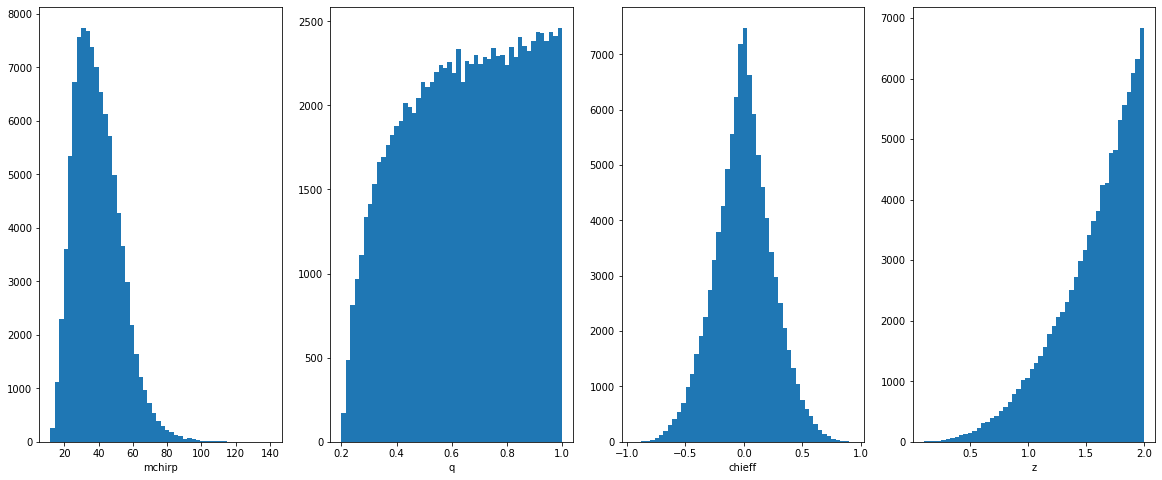

In [96]:
fig, axs = plt.subplots(1,4, figsize=(20,8))
for param, ax in zip(['mchirp','q','chieff','z'], axs):
    _ = ax.hist(df[param], bins=50)
    ax.set_xlabel(param)

In [42]:
df.to_hdf(os.path.join(output_directory, 'LVC_prior.hdf5'), key='samples')

##### Compare with prior samples from GWTC-2

In [51]:
event='GW190521'
#f = h5py.File(GWTC2_path+event+'.h5')
prior = pd.DataFrame(np.load(GWTC2_path+event+'_prior.npy'))
post = pd.read_hdf(GWTC2_path+event+'.h5', key='PublicationSamples/posterior_samples')
prior['mchirp'] = m1m2_to_mchirp(prior['mass_1_source'],prior['mass_2_source'])

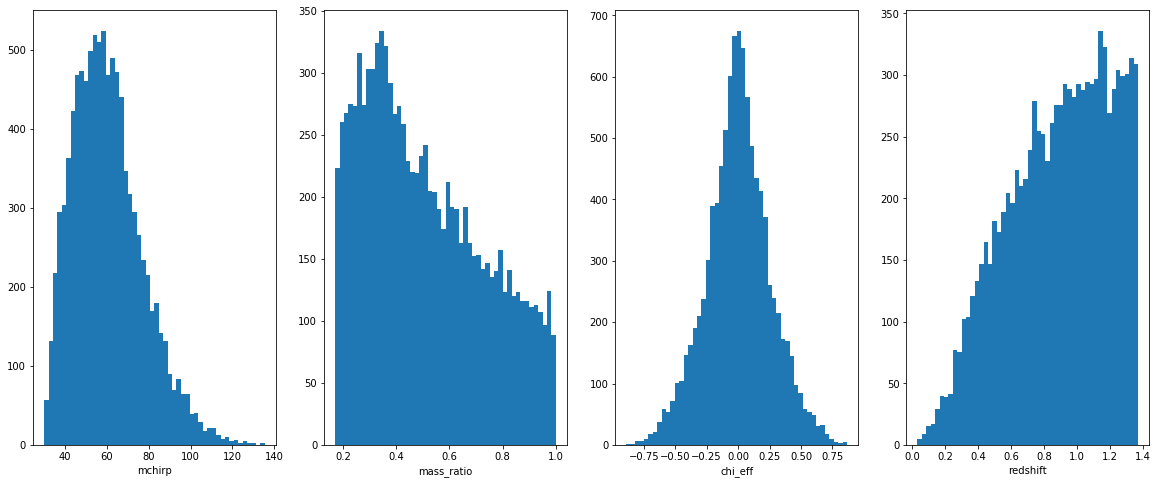

In [52]:
fig, axs = plt.subplots(1,4, figsize=(20,8))
for param, ax in zip(['mchirp','mass_ratio','chi_eff','redshift'], axs):
    _ = ax.hist(prior[param], bins=50)
    ax.set_xlabel(param)